# Using metadata features (in CNN)

In ISIC 2019 data, we have access to image metadata, such as patients' age, sex, and antanomical location of lesion. Let's utilize those. We propose using metadata in conjuction with CNN (EfficientNet) that was pretrained in a previous notebook. Here's the rough block diagram:

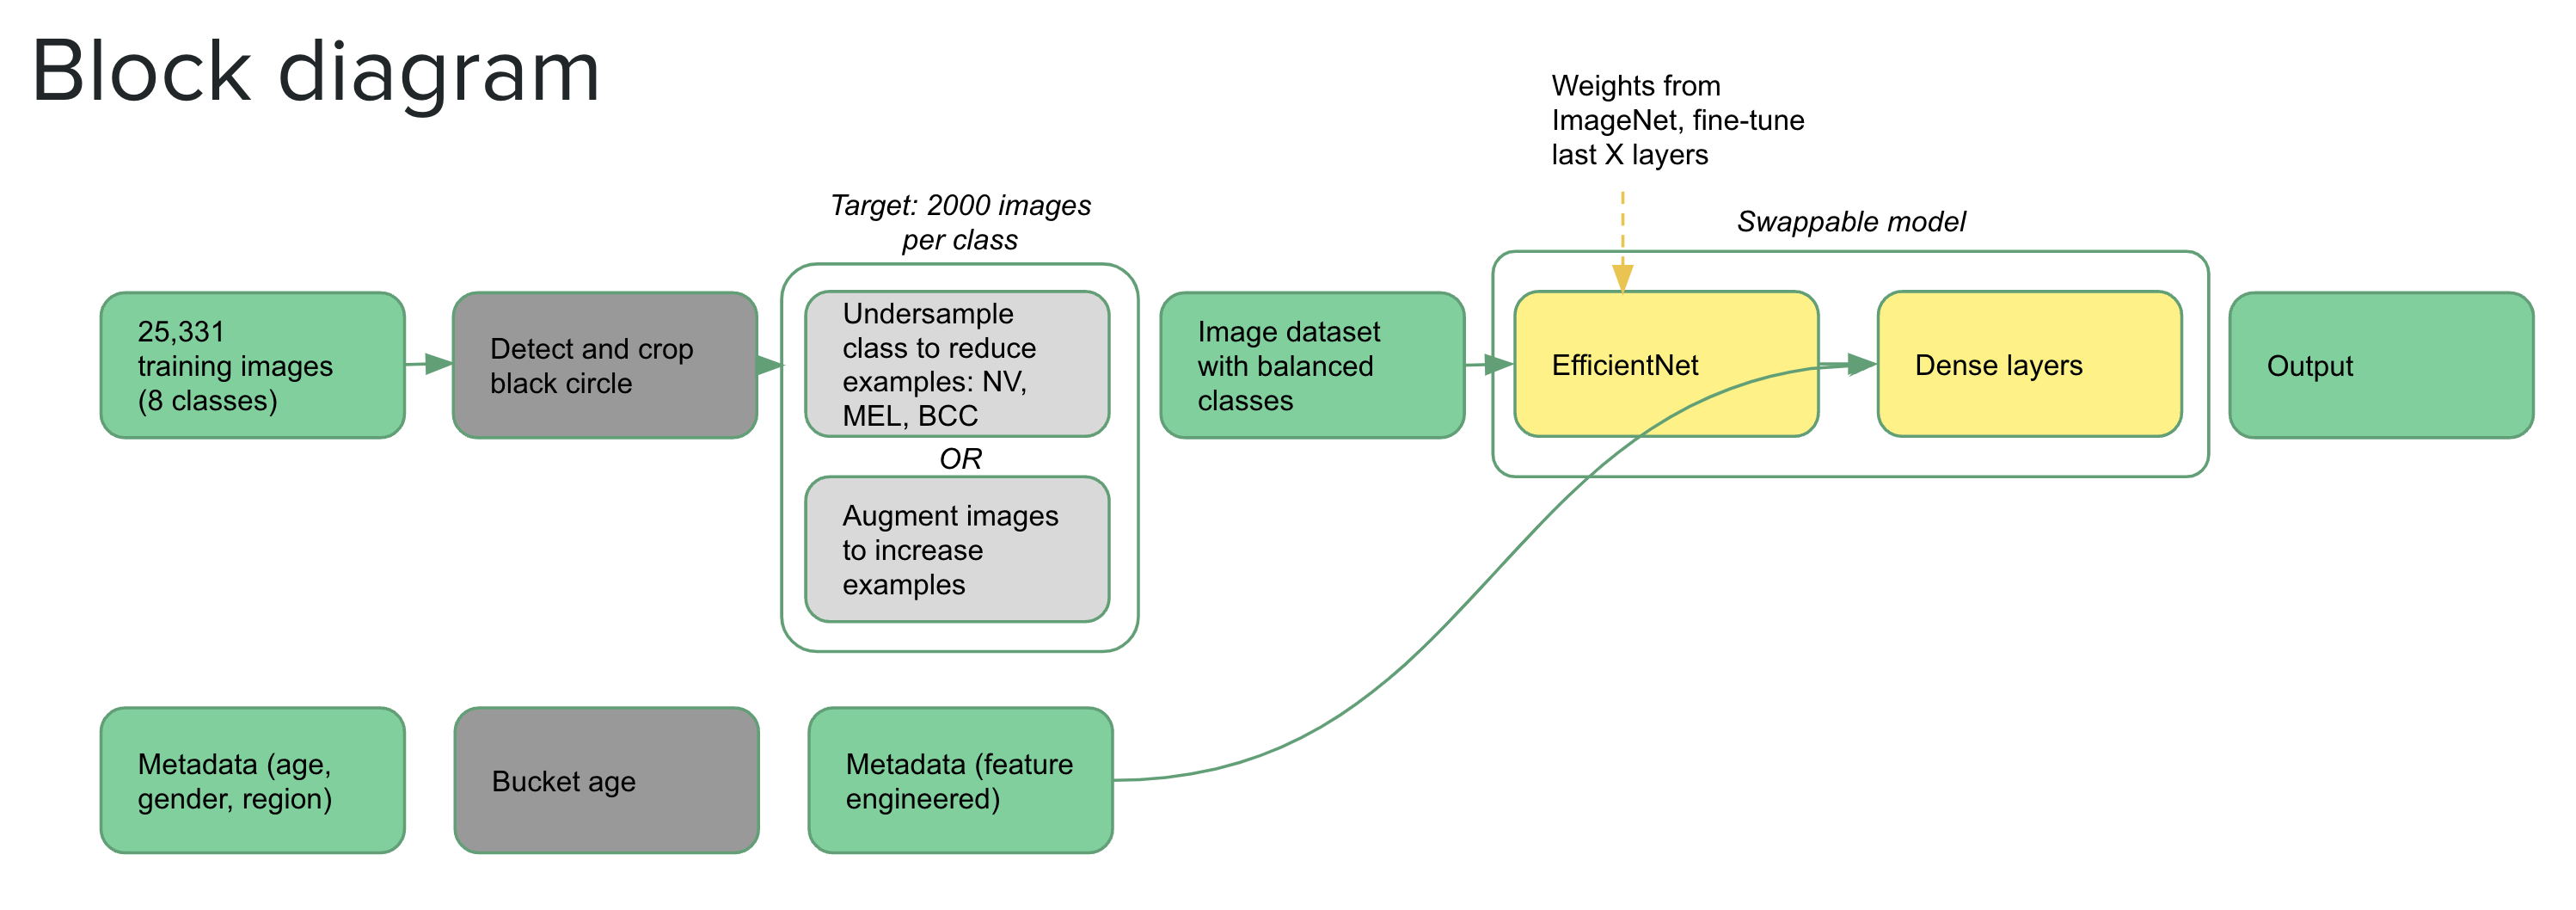

In [ ]:
!pip install tensorflow-addons
!pip install pydot

In terminal, run this: `apt install graphviz`

In [4]:
from importlib import reload
import time

from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn import metrics as sklearn_metrics

import constants
import skin_class

In [5]:
random_seed = 21

tf.keras.backend.clear_session()
metrics = [
    "accuracy",
    tf.metrics.Precision(name="precision"),
    tf.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
    tfa.metrics.F1Score(num_classes=8, name="f1_score"),
]

# For quality of life
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mark = "*"
        if epoch % 10 == 9:
            mark = "*|"
        print(mark, end="")

        with open("progress_log.txt", "a") as logf:
            logf.write(f"{time.time()} Done training on {epoch=}, {logs=}\n")


def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

### Minor EDA on metadata

In [6]:
df_metadata = pd.read_csv("isic_data/ISIC_2019_Training_Metadata.csv")
print("\nhead\n", df_metadata.head(), sep="")
print("\ndescribe:\n", df_metadata.describe(), sep="")
print("\nTotal NA rows:\n", df_metadata.isna().sum(), sep="")


head
          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male

describe:
         age_approx
count  24894.000000
mean      54.028481
std       18.130971
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max       85.000000

Total NA rows:
image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64


In [6]:
print("\nage_approx\n", df_metadata["age_approx"].value_counts(), sep="")
print("\nsex\n", df_metadata["sex"].value_counts(), sep="")
print("\nanatom_site_general\n", df_metadata["anatom_site_general"].value_counts(), sep="")


age_approx
45.0    2585
50.0    2489
40.0    2246
55.0    2170
70.0    2120
65.0    2075
60.0    2036
75.0    1796
35.0    1651
80.0    1459
85.0    1319
30.0    1199
25.0     677
20.0     388
15.0     375
10.0     142
5.0      113
0.0       54
Name: age_approx, dtype: int64

sex
male      13286
female    11661
Name: sex, dtype: int64

anatom_site_general
anterior torso     6915
lower extremity    4990
head/neck          4587
upper extremity    2910
posterior torso    2787
palms/soles         398
oral/genital         59
lateral torso        54
Name: anatom_site_general, dtype: int64


### Making metadata ready for Tensorflow
- given an image name, get the corresponding row of metadata
- given a tf.Dataset of training (or validation, or test) images, how do we get similarly a tf.Dataset of just metadata that will supply examples in the same order?
- fill in NA as its own category for all 3 features
- bin age into categories (instead of float; original data already bins by 5 years)

In [9]:
df_metadata = pd.read_csv("isic_data/ISIC_2019_Training_Metadata.csv")
random_seed = 21

def get_metadata_from_image_filename(filename: str, index_name=None):
    fn = filename.split("/")[-1]
    fn = fn.split(".jpg")[0].split(".jpeg")[0]  # both kinds of spelling
    fn_no_aug = fn.split("_aug_")[0]
    
    # Lookup
    try:
        ret = df_metadata[df_metadata["image"]==fn_no_aug].iloc[0]
    except Exception as e:
        print(f"{fn_no_aug=}")
        raise e
    ret.name = index_name if index_name is not None else fn
    return ret

# Next, we need a function that, when given a tensorflow dataset, we'll be able to retrive 
# a sparse version of metadata (since all 3 are "categorical" to an extent)

# Convert age into categorical bins (data already comes in bins of 5)
age_buckets = np.sort(df_metadata["age_approx"].astype(str).unique())
int_to_bucket = {i: ab for i, ab in enumerate(age_buckets)}
bucket_to_int = {ab: i for i, ab in enumerate(age_buckets)}

# Likewise for anatom_site_general
anatom_list = np.sort(df_metadata["anatom_site_general"].astype(str).unique())
int_to_anatom = {i: ana for i, ana in enumerate(anatom_list)}
anatom_to_int = {ana: i for i, ana in enumerate(anatom_list)}

# And also for sex
sex_list = np.sort(df_metadata["sex"].astype(str).unique())
int_to_sex = {i: s for i, s in enumerate(sex_list)}
sex_to_int = {s: i for i, s in enumerate(sex_list)}

# Get a grand vocabulary list
vocab = {}
vocab_index = 0
for group_name, group in {
    "age_approx": age_buckets,
    "anatom_site_general": anatom_list,
    "sex": sex_list,
}.items():
    for group_item in group:
        vocab[vocab_index] = group_name + ": " + group_item
        vocab_index += 1

print("Vocabulary of sparse categorical:")
for i, v in vocab.items():
    print(f"{i}: {v}")

def get_sparse_metadata_from_tf_dataset(ds: tf.data.Dataset):
    # loop paths, put into pd.DataFrame
    subset_metadata = []
    for i, file_path in enumerate(ds.file_paths):
        subset_metadata.append(get_metadata_from_image_filename(file_path, i))

    df_metadata_subset = pd.DataFrame(subset_metadata)    

    df_metadata_subset["age_approx_sparse"] = (
        df_metadata_subset["age_approx"].astype(str).apply(lambda x: bucket_to_int[x])
    )

    feature_sparse_1 = tf.keras.utils.to_categorical(df_metadata_subset["age_approx_sparse"])

    df_metadata_subset["anatom_site_general_sparse"] = (
        df_metadata_subset["anatom_site_general"].astype(str).apply(lambda x: anatom_to_int[x])
    )

    feature_sparse_2 = tf.keras.utils.to_categorical(df_metadata_subset["anatom_site_general_sparse"])

    df_metadata_subset["sex_sparse"] = (
        df_metadata_subset["sex"].astype(str).apply(lambda x: sex_to_int[x])
    )

    feature_sparse_3 = tf.keras.utils.to_categorical(df_metadata_subset["sex_sparse"])

    # Concat everything together into one input array
    feature_sparse_all = np.concatenate([feature_sparse_1, feature_sparse_2, feature_sparse_3], axis=1)
    print(f"{feature_sparse_all.shape=}")
    
    return feature_sparse_all


Vocabulary of sparse categorical:
0: age_approx: 0.0
1: age_approx: 10.0
2: age_approx: 15.0
3: age_approx: 20.0
4: age_approx: 25.0
5: age_approx: 30.0
6: age_approx: 35.0
7: age_approx: 40.0
8: age_approx: 45.0
9: age_approx: 5.0
10: age_approx: 50.0
11: age_approx: 55.0
12: age_approx: 60.0
13: age_approx: 65.0
14: age_approx: 70.0
15: age_approx: 75.0
16: age_approx: 80.0
17: age_approx: 85.0
18: age_approx: nan
19: anatom_site_general: anterior torso
20: anatom_site_general: head/neck
21: anatom_site_general: lateral torso
22: anatom_site_general: lower extremity
23: anatom_site_general: nan
24: anatom_site_general: oral/genital
25: anatom_site_general: palms/soles
26: anatom_site_general: posterior torso
27: anatom_site_general: upper extremity
28: sex: female
29: sex: male
30: sex: nan


In [46]:
# Test the function: Load a dataset (trying it out on validation set first because it's smaller)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)
val_input_metadata = get_sparse_metadata_from_tf_dataset(validation_ds)
print(f"\n{val_input_metadata=}")

Found 2026 files belonging to 8 classes.
feature_sparse_all.shape=(2026, 31)

val_input_metadata=array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]], dtype=float32)


## Specifying Tensorflow multi-input model

In [6]:
tf.keras.backend.clear_session()

# CNN branch
inputs_en = tf.keras.Input(shape=(224, 224, 3))

## Load previous model
en_model_full = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_model.h5")
en_model_cnn_only = en_model_full.layers[1]  # just the EfficientNet portion
# Should EN be trainable?

x2 = en_model_cnn_only(inputs_en)

# Metadata branch
inputs_metadata = tf.keras.Input(shape=(31))

# Concatenate the two
x = tf.concat([x2, inputs_metadata], axis=1)

# Some Dense layers -- just a simple one for now
x = tf.keras.layers.Dense(10)(x)

# output
outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model([inputs_en, inputs_metadata], outputs)

model.summary()

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-11-28 16:50:33.643 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:6028 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-28 16:50:33.705 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:6028 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                       

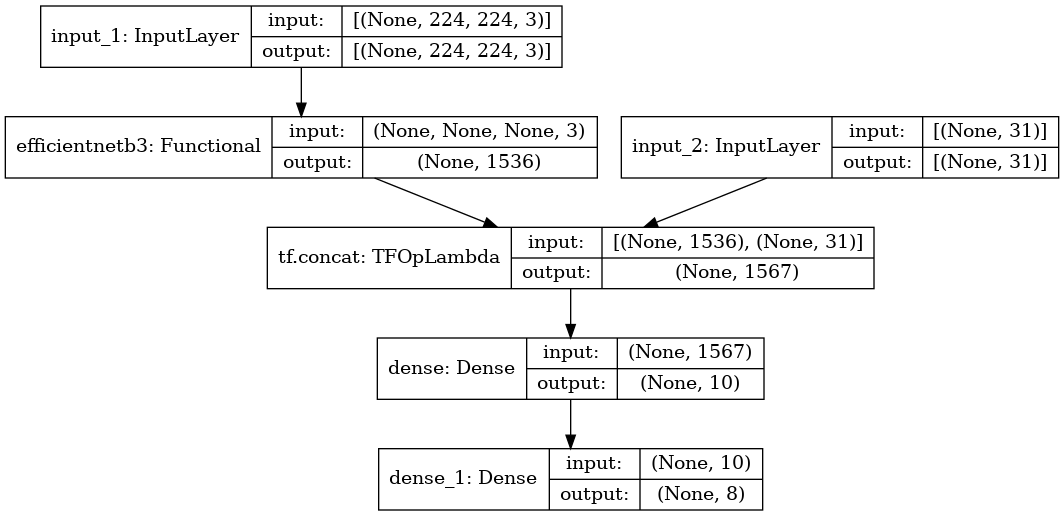

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
# Feed in multiple inputs (no training, just seeing if the piping is correct)
random_seed = 21
train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=1,  # default
    label_mode='categorical',
    shuffle=False,  # to keep image order consistent
)

# Creating a tf.Dataset with metadata
train_input_metadata = get_sparse_metadata_from_tf_dataset(train_ds)
ds_metadata = tf.data.Dataset.from_tensor_slices(train_input_metadata)

# Splitting up image and label
ds_unbatched = train_ds.unbatch()

ds_labels = ds_unbatched.map(lambda x, y: y)
ds_images = ds_unbatched.map(lambda x, y: x)

Found 16000 files belonging to 8 classes.
feature_sparse_all.shape=(16000, 31)


In [84]:
# Testing piping multiple inputs into model.predict
result = model.predict(
    [
        np.array(list(ds_images.take(2).as_numpy_iterator())),
        np.array(list(ds_metadata.take(2).as_numpy_iterator())),
    ]
)
result

array([[6.64500476e-06, 2.86757626e-07, 5.83313386e-06, 9.99743521e-01,
        2.35747822e-04, 7.90406284e-06, 6.95750879e-09, 1.03402309e-09],
       [4.73761149e-02, 1.42652262e-03, 5.68992342e-04, 9.49121892e-01,
        1.26570754e-03, 1.22093945e-04, 1.11621357e-05, 1.07531334e-04]],
      dtype=float32)

In [44]:
def create_dataset_generator(ds_images, ds_metadata, ds_labels, batch_size=5):
    def argument_free_generator():
        tf.keras.backend.clear_session()
        n_examples = ds_metadata.cardinality().numpy()
        
        images_iter = ds_images.as_numpy_iterator()
        metadatas_iter = ds_metadata.as_numpy_iterator()
        labels_iter = ds_labels.as_numpy_iterator()
        
        for _ in range(n_examples // batch_size + bool(int(n_examples % batch_size))):
            images, metadatas, labels = [], [], []
            for _ in range(batch_size):
                try:
                    images.append(next(images_iter))
                    metadatas.append(next(metadatas_iter))
                    labels.append(next(labels_iter))
                except StopIteration:
                    pass
            
            yield {"input_1": images, "input_2": metadatas}, labels
            del images, metadatas, labels
            
    return argument_free_generator

# Create the generator which yields inputs and outputs
test_amount = 12
generator = create_dataset_generator(
    ds_images.take(test_amount),
    ds_metadata.take(test_amount),
    ds_labels.take(test_amount),
)

ds_repackaged = tf.data.Dataset.from_generator(
    generator,
    output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
    output_shapes=({"input_1": (None, 224, 224, 3), "input_2": (None, 31)}, (None, 8)),
)

In [9]:
# Now attempting to fit! without validation for now (one step at a time)
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)


history = model.fit(
    ds_repackaged,
    epochs=1,
    batch_size=32,
    # callbacks=callbacks,
    verbose=1,
)

3/3 [==============================] - 16s 923ms/step - loss: 3.9894 - accuracy: 0.5833 - precision: 0.6364 - recall: 0.5833 - auc_pr: 0.6726 - auc_roc: 0.7812 - f1_score: 0.0921


image number 0
expected path: isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0024468.jpg
age: 75.0
anatomy: head/neck
sex: male
target: AK
image number 1
expected path: isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0024468_aug_00.jpeg
age: 75.0
anatomy: head/neck
sex: male
target: AK
image number 2
expected path: isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0024468_aug_01.jpeg
age: 75.0
anatomy: head/neck
sex: male
target: AK
image number 3
expected path: isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0024468_aug_02.jpeg
age: 75.0
anatomy: head/neck
sex: male
target: AK
image number 4
expected path: isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0024470.jpg
age: 60.0
anatomy: upper extremity
sex: male
target: AK


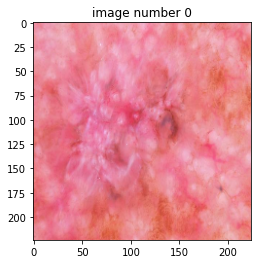

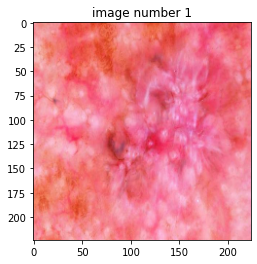

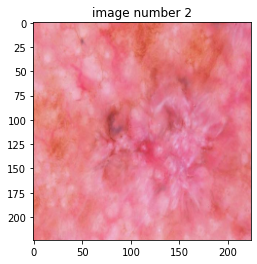

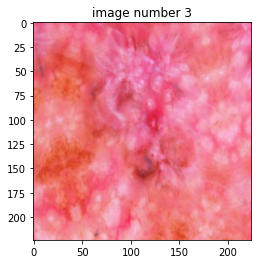

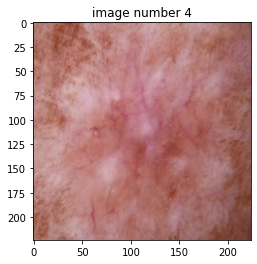

In [44]:
# Verifying image and label paired up correctly
some_data = generator()
one_batch = next(some_data)
for i in range(5):
    img = one_batch[0]["input_1"][i]
    md = one_batch[0]["input_2"][i]
    lbl = one_batch[1][i]

    # Display
    print("image number", i)
    print("expected path:", train_ds.file_paths[i])
    plt.figure()
    plt.imshow(img.astype(int))
    plt.title(f"image number {i}")

    print("age:", int_to_bucket[np.argmax(md[:19])])
    print("anatomy:", int_to_anatom[np.argmax(md[19:28])])
    print("sex:", int_to_sex[np.argmax(md[28:])])

    print("target:", train_ds.class_names[np.argmax(lbl)])
    


Package everything into a neat function

In [7]:
def repackage_dataset_with_metadata(ds: tf.data.Dataset, batch_size=32, include_filepaths=False):
    """Supply either train, validation, or test tf.data.Dataset."""
    input_metadata = get_sparse_metadata_from_tf_dataset(ds)
    ds_metadata = tf.data.Dataset.from_tensor_slices(input_metadata)
    ds_filepath = tf.data.Dataset.from_tensor_slices(ds.file_paths)

    # Splitting up image and label
    ds_unbatched = ds.unbatch()

    ds_labels = ds_unbatched.map(lambda x, y: y)
    ds_images = ds_unbatched.map(lambda x, y: x)

    def create_dataset_generator(
        ds_images, ds_metadata, ds_labels, ds_filepath, batch_size=batch_size, include_filepaths=include_filepaths
    ):
        def argument_free_generator():
            tf.keras.backend.clear_session()
            n_examples = ds_metadata.cardinality().numpy()

            images_iter = ds_images.as_numpy_iterator()
            metadatas_iter = ds_metadata.as_numpy_iterator()
            labels_iter = ds_labels.as_numpy_iterator()
            filepaths_iter = ds_filepath.as_numpy_iterator()

            for _ in range(n_examples // batch_size + bool(int(n_examples % batch_size))):
                images, metadatas, labels, filepaths = [], [], [], []
                for _ in range(batch_size):
                    try:
                        images.append(next(images_iter))
                        metadatas.append(next(metadatas_iter))
                        labels.append(next(labels_iter))
                        filepaths.append(next(filepaths_iter))
                    except StopIteration:
                        pass

                if include_filepaths:
                    yield (
                        {
                            "input_1": images,
                            "input_2": metadatas,
                            "filepath": filepaths,
                        },
                        labels,
                    )
                else:
                    yield (
                        {
                            "input_1": images,
                            "input_2": metadatas,
                        },
                        labels,
                    )
                del images, metadatas, labels, filepaths

        return argument_free_generator

    # Create the generator which yields inputs and outputs
    generator = create_dataset_generator(
        ds_images,
        ds_metadata,
        ds_labels,
        ds_filepath,
        batch_size=batch_size,
        include_filepaths=include_filepaths,
    )

    ds_repackaged = tf.data.Dataset.from_generator(
        generator,
        output_types=(
            ({"input_1": tf.float32, "input_2": tf.float32, "filepath": tf.string}, tf.float32)
            if include_filepaths
            else ({"input_1": tf.float32, "input_2": tf.float32}, tf.float32)
        ),
        output_shapes=(
            ({"input_1": (None, 224, 224, 3), "input_2": (None, 31), "filepath": (None,)}, (None, 8))
            if include_filepaths
            else ({"input_1": (None, 224, 224, 3), "input_2": (None, 31)}, (None, 8))
        ),
    )
    
    return ds_repackaged

## "For-real" training!

Now that we have the individual components piped together, let's fit!

In [9]:
# Load data
random_seed = 21
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=1,  # default
    label_mode='categorical',
    shuffle=False,  # to keep image order consistent
)
train_ds_repackaged = repackage_dataset_with_metadata(train_ds, batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=1,  # default
    label_mode='categorical',
    shuffle=False,  # to keep image order consistent
)
validation_ds_repackaged = repackage_dataset_with_metadata(validation_ds, batch_size=batch_size)


Found 16000 files belonging to 8 classes.
feature_sparse_all.shape=(16000, 31)
Found 2026 files belonging to 8 classes.
feature_sparse_all.shape=(2026, 31)


feature_sparse_all.shape=(16000, 31)
image number 0
expected filepath b'isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0062743.jpg'
age: 40.0
anatomy: head/neck
sex: female
target: AK
image number 1
expected filepath b'isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0062743_aug_00.jpeg'
age: 40.0
anatomy: head/neck
sex: female
target: AK
image number 2
expected filepath b'isic_data/ISIC_2019_Training_Augmented/AK/ISIC_0062743_aug_01.jpeg'
age: 40.0
anatomy: head/neck
sex: female
target: AK


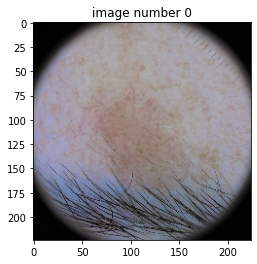

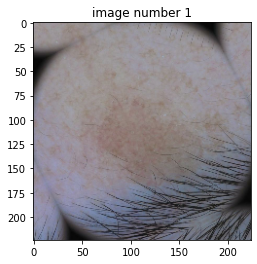

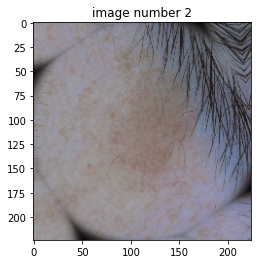

In [114]:
# Check that image matches metadata
peek_ds_repackaged = repackage_dataset_with_metadata(train_ds, batch_size=batch_size, include_filepaths=True)

peek_ds = peek_ds_repackaged
peek_one = list(peek_ds.shuffle(100).take(1).as_numpy_iterator())

batch_x, batch_y = peek_one[0]

for img_id in range(3):
    img = batch_x["input_1"][img_id]
    md = batch_x["input_2"][img_id]
    fp = batch_x["filepath"][img_id]
    lbl = batch_y[img_id]

    # Display
    print("image number", img_id)
    print("expected filepath", fp)
    # print("expected path:", train_ds.file_paths[i])
    plt.figure()
    plt.imshow(img.astype(int))
    plt.title(f"image number {img_id}")

    print("age:", int_to_bucket[np.argmax(md[:19])])
    print("anatomy:", int_to_anatom[np.argmax(md[19:28])])
    print("sex:", int_to_sex[np.argmax(md[28:])])

    print("target:", train_ds.class_names[np.argmax(lbl)])

In [9]:
# Choose a model
tf.keras.backend.clear_session()

# CNN branch
inputs_en = tf.keras.Input(shape=(224, 224, 3))

## Load previous model
en_model_full = tf.keras.models.load_model("saved_models/cnn_efficientnet/efficientnet0_16k_model.h5")
en_model_cnn_only = en_model_full.layers[2]  # just the EfficientNet portion
# Make pre-trained (fine-tuned) EfficientNet not trainable
en_model_cnn_only.trainable = False

x2 = en_model_cnn_only(inputs_en)

# Metadata branch
inputs_metadata = tf.keras.Input(shape=(31))

# Concatenate the two
x = tf.concat([x2, inputs_metadata], axis=1)

# Some Dense layers
for dense_layer_num in range(2):  # number of hidden layers
    x = tf.keras.layers.Dense(
        25,
        activation="relu",
        name=f"Dense_{dense_layer_num}",
    )(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

# output
outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model([inputs_en, inputs_metadata], outputs)

model.summary()

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-02 19:15:50.585 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:55 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-02 19:15:50.611 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:55 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                           

In [13]:
mini_en = tf.keras.Sequential(model.layers[:2])
output_from_en = mini_en.predict([
    np.array(list(ds_images.take(2).as_numpy_iterator())),
])

In [19]:
only_input_2 = tf.keras.Sequential(
    [
        model.layers[2],
        tf.keras.layers.BatchNormalization(),
    ]
)
only_input_2.predict([
    np.array(list(ds_metadata.take(2).as_numpy_iterator())),
])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
      dtype=float32)

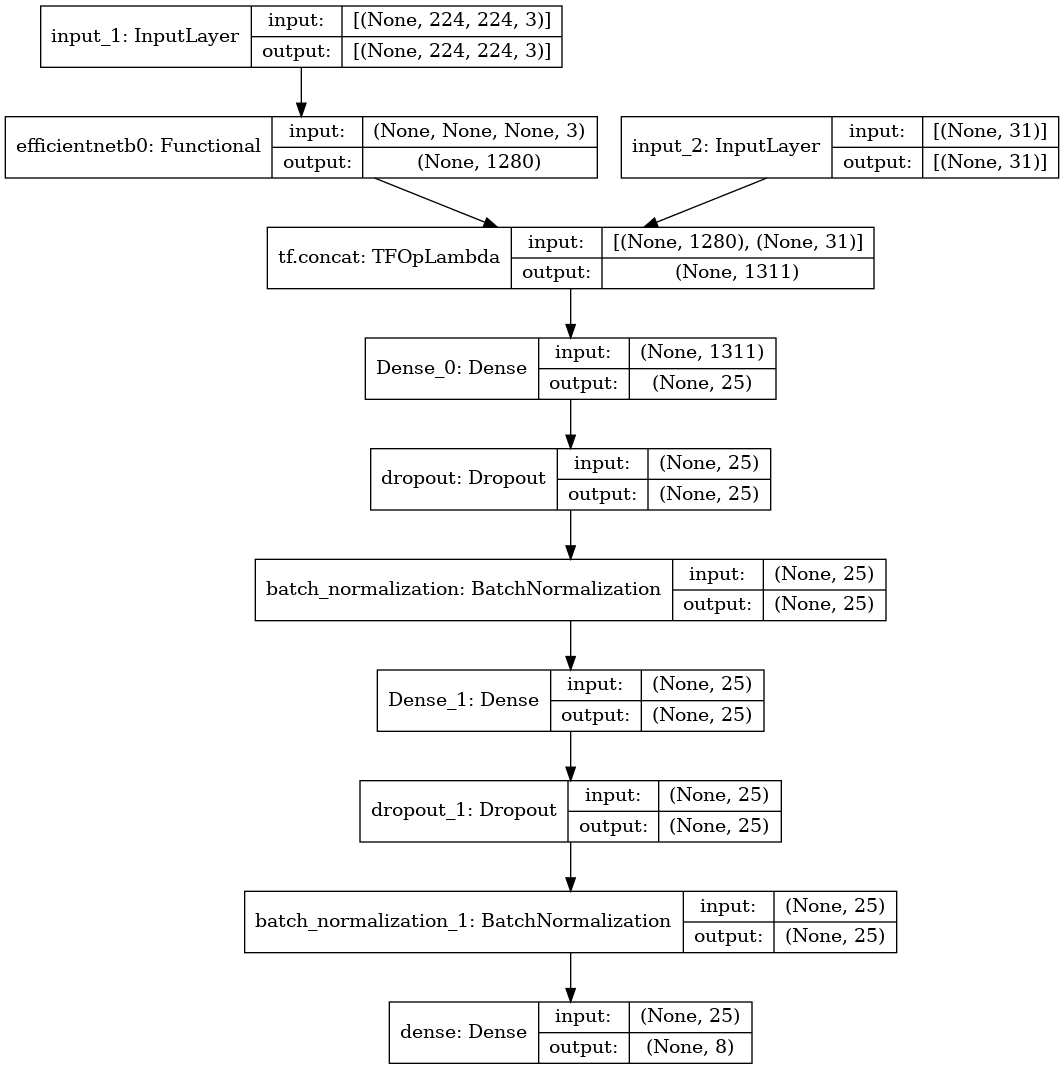

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
train_ds_repackaged_reshuffled = train_ds_repackaged.shuffle(buffer_size=100, seed=random_seed, reshuffle_each_iteration=True)

Epoch 1/10
500/500 [==============================] - 83s 126ms/step - loss: 2.2740 - accuracy: 0.1157 - precision: 0.1332 - recall: 0.0042 - auc_pr: 0.1216 - auc_roc: 0.4872 - f1_score: 0.1122 - val_loss: 2.1111 - val_accuracy: 0.1594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_pr: 0.1319 - val_auc_roc: 0.5117 - val_f1_score: 0.1085
Epoch 2/10
500/500 [==============================] - 97s 175ms/step - loss: 2.1243 - accuracy: 0.1194 - precision: 0.2000 - recall: 1.2500e-04 - auc_pr: 0.1236 - auc_roc: 0.4956 - f1_score: 0.1128 - val_loss: 2.0760 - val_accuracy: 0.1570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_pr: 0.1432 - val_auc_roc: 0.5395 - val_f1_score: 0.1032
Epoch 3/10
500/500 [==============================] - 69s 121ms/step - loss: 2.1014 - accuracy: 0.1215 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_pr: 0.1241 - auc_roc: 0.4955 - f1_score: 0.1109 - val_loss: 2.0618 - val_accuracy: 0.2340 - val_precision: 0.0000e+00 - val_recall: 

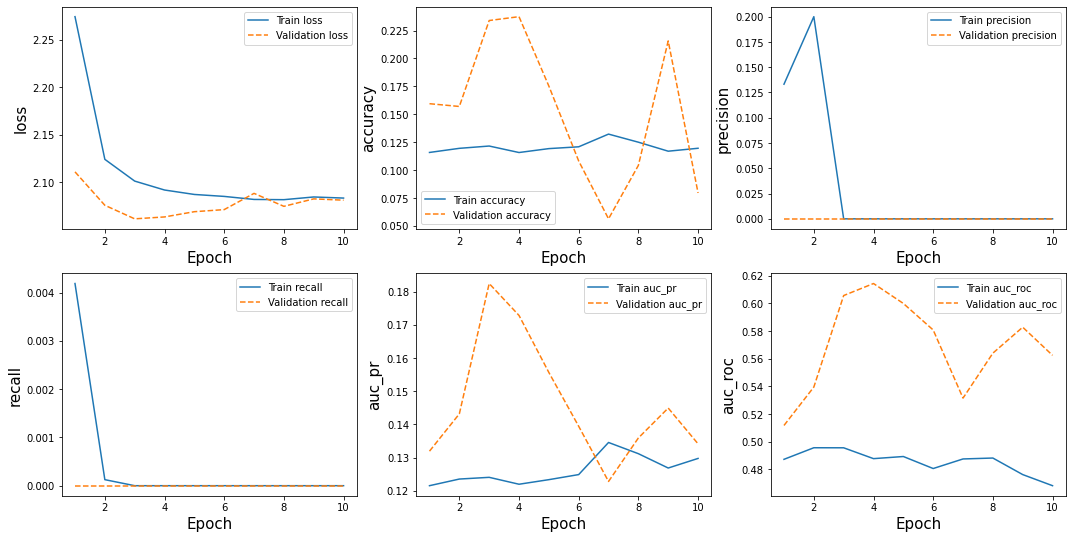

In [11]:
# Fit it
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(5e-4),
    metrics=metrics,
)

callbacks = [
    # CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max'),
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

history = model.fit(
    train_ds_repackaged_reshuffled,
    validation_data=validation_ds_repackaged,
    epochs=10,
    batch_size=32,
    # callbacks=callbacks,
    verbose=1,
)

plot_history_df(pd.DataFrame(history.history))

Results look terrible! Wonder what happened. Let's try a slightly different structure: let's also include the pretrained dense layers from earlier, and start with last weights (so, not from randomized weights). Also, add a couple dense layers on metadata "arm" before concatentating.

In [7]:
# # Temporary code to wait on other model
# import IPython
# from os.path import exists
# import time

# path_to_other_notebook_output = "saved_models/cnn_efficientnet/efficientnet3_16k_model.h5"

# while not exists(path_to_other_notebook_output):
#     IPython.display.clear_output()
#     print("not ready:", time.time())
#     time.sleep(30)
    
# IPython.display.clear_output()

# Choose a model
tf.keras.backend.clear_session()

# CNN branch
inputs_en = tf.keras.Input(shape=(224, 224, 3), name="input_1")

## Load previous model
en_model_full = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model.h5")
# Make pre-trained EfficientNet + Dense model not trainable
en_model_full.trainable = True

x1 = inputs_en
for l in en_model_full.layers[1:-1]:  # skip existing input layer, and last classification dense layer
    l.trainable = False  # Freeze training
    # if isinstance(l, tf.keras.layers.Dense):
    #     l.trainable = True
    x1 = l(x1)

# Metadata branch
inputs_metadata = tf.keras.Input(shape=(31), name="input_2")
x2 = inputs_metadata

# Add a couple dense layers
for dense_layer_metadata_num in range(2):  # number of hidden layers
    x2 = tf.keras.layers.Dense(
        16,
        activation="relu",
        name=f"Dense_metadata_{dense_layer_metadata_num}",
        kernel_initializer=tf.keras.initializers.Zeros(),  # Start from no influence, slowly increase
    )(x2)
    x2 = tf.keras.layers.Dropout(0.1)(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)

# Concatenate the two
x = tf.concat([x1, x2], axis=1)

# Some Dense layers
for dense_layer_combined_num in range(1):  # number of hidden layers
    x = tf.keras.layers.Dense(
        16,
        activation="relu",
        name=f"Dense_combined_{dense_layer_combined_num}",
    )(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

# output
outputs = tf.keras.layers.Dense(8, activation="softmax", name="dense_final")(x) # Classification layer

model = tf.keras.Model([inputs_en, inputs_metadata], outputs)

model.summary()

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-02 19:53:47.196 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:1021 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-02 19:53:47.260 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:1021 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 31)]         0                                       

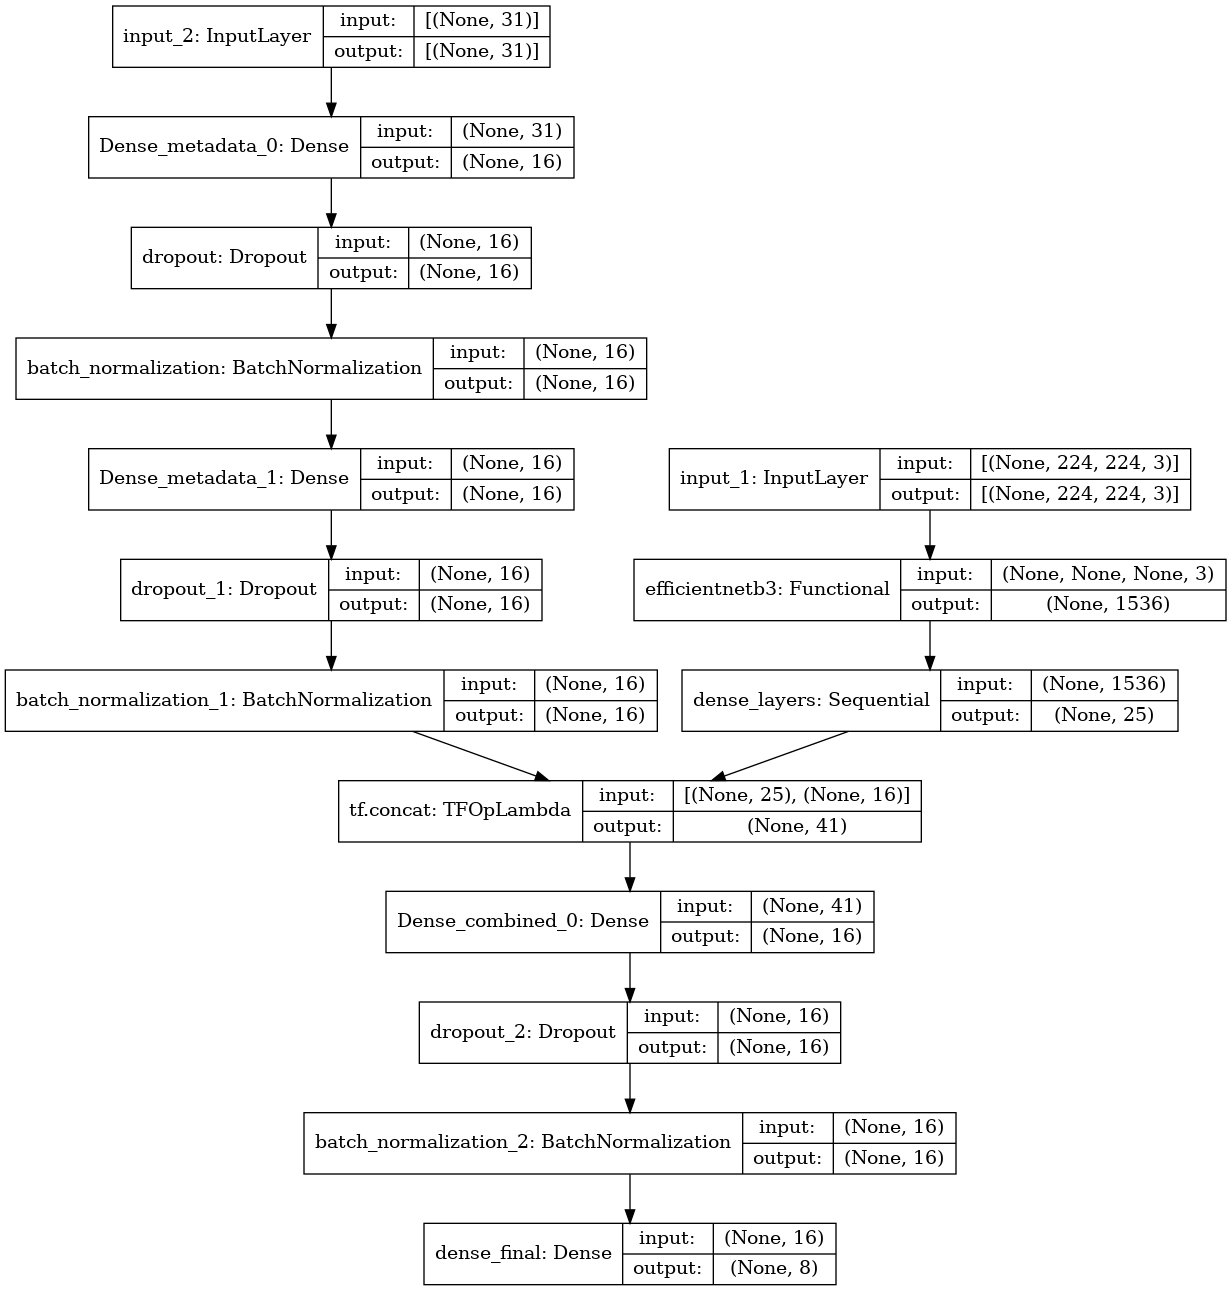

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

**********|**********|**

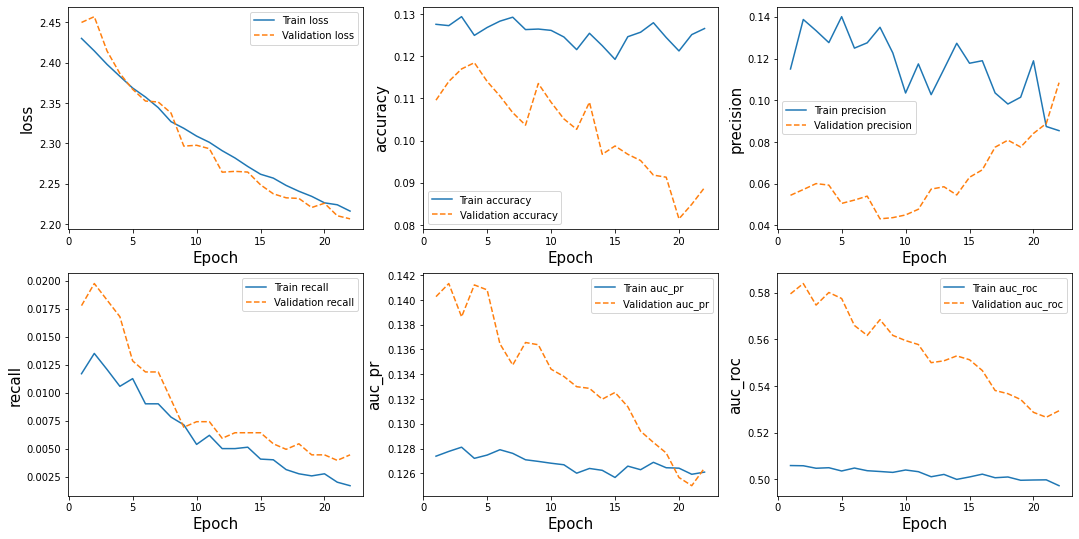

In [11]:
# Fit it
model.compile(
    loss='categorical_crossentropy',
    # optimizer="adam",
    optimizer=tf.keras.optimizers.Adam(1e-5),  # start low
    metrics=metrics,
)

callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max'),
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

train_ds_repackaged_reshuffled = train_ds_repackaged.shuffle(buffer_size=100, seed=random_seed, reshuffle_each_iteration=True)

history = model.fit(
    train_ds_repackaged_reshuffled,
    validation_data=validation_ds_repackaged,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
plot_history_df(history_df)

In [12]:
model.save("saved_models/cnn_metadata/cnn_efficientnetb0_metadata_model.h5")
history_df.to_csv("saved_models/cnn_metadata/cnn_efficientnetb0_metadata_model_history.csv")

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
# Extended training
model.compile(
    loss='categorical_crossentropy',
    # optimizer="adam",
    optimizer=tf.keras.optimizers.Adam(1e-5),  # start a little but higher?
    metrics=metrics,
)

callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max'),  # Adjust patience
]

history_2 = model.fit(
    train_ds_repackaged_reshuffled,
    validation_data=validation_ds_repackaged,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)

history_2_df = pd.DataFrame(history_2.history)

^ Stopped the above fitting halfway because precision and recall floored just like the previous models (checked via custom external logger). Here's the last epoch's log:

```
1670020615.4446385 Done training on epoch=47,
logs={
'loss': 2.102478504180908,
'accuracy': 0.13587500154972076,
'precision': 0.0,
'recall': 0.0,
'auc_pr': 0.12807969748973846,
'auc_roc': 0.4926031529903412,
'f1_score': array([0.18467876, 0.22689939, 0.07252946, 0.10658307, 0.13254495, 0.10297666, 0.10836058, 0.12329121], dtype=float32),
'val_loss': 2.0956480503082275,
'val_accuracy': 0.08785784989595413,
'val_precision': 0.0,
'val_recall': 0.0,
'val_auc_pr': 0.11896758526563644,
'val_auc_roc': 0.4858182370662689,
'val_f1_score': array([0.12151898, 0.2       , 0.01705757, 0.        , 0.08595042, 0.13751088, 0.00833333, 0.01081081], dtype=float32)}
```

## Evaluate anyways for numbers

In [10]:
random_seed = 21
batch_size = 32
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=1,  # default
    label_mode='categorical',
    shuffle=False,
)
test_ds_repackaged = repackage_dataset_with_metadata(test_ds, batch_size=batch_size)

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn_metadata/cnn_efficientnetb0_metadata_model.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

results = best_model.evaluate(test_ds_repackaged)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

Found 5066 files belonging to 8 classes.
feature_sparse_all.shape=(5066, 31)
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-06 00:33:44.203 tensorflow-2-6-gpu-py-ml-t3-medium-2e2c7c0afde0c32682030cb02477:35 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-06 00:33:44.275 tensorflow-2-6-gpu-py-ml-t3-medium-2e2c7c0afde0c32682030cb02477:35 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
159/159 [==============================] - 543s 3s/step - loss: 2.1921 - accuracy: 0.1005 - precision: 0.0452 - recall: 0.0018 - auc_pr: 0.1291 - auc_roc: 0.5407 - f1_score: 0.0715
loss	: 2.192
accuracy	: 0.100
precision	: 0.045
reca

In [ ]:
test_preds = best_model.predict(test_ds_repackaged)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_dense = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels_dense, axis=1)

labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(labels_sparse)
y_pred = sorted_to_real_fn(test_preds_sparse)


Classification Report
              precision    recall  f1-score   support

         MEL      0.248     0.333     0.284       895
          NV      0.371     0.035     0.065      2592
         BCC      0.146     0.069     0.093       684
          AK      0.035     0.381     0.064       160
         BKL      0.007     0.010     0.008       502
          DF      0.014     0.045     0.022        44
        VASC      0.000     0.000     0.000        47
         SCC      0.045     0.028     0.035       142

    accuracy                          0.100      5066
   macro avg      0.108     0.113     0.071      5066
weighted avg      0.257     0.100     0.100      5066

Accuracy: 0.1005
ROC AUC: 0.5219


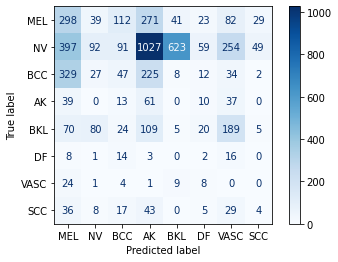

In [13]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(labels_dense, test_preds, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Last-ditch effort

In a last-ditch effort, we'll try replicating the approaches outlined in [this paper](https://methods-x.com/article/S2215-0161(20)30083-2/fulltext) which has a similar approach of combining image data with metadata. Some things that differ in their approach:

- they use way more neurons in their metadata arm's dense layers, _and_ layer after concatenation
- they have a much higher dropout rate
- age is treated as a numerical input (not categorical bins)

In [117]:
# Choose a model
tf.keras.backend.clear_session()

# CNN branch
inputs_en = tf.keras.Input(shape=(224, 224, 3), name="input_1")

## Load previous model
en_model_full = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model.h5")
# Make pre-trained EfficientNet + Dense model not trainable
en_model_full.trainable = True

# Light augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.1),
    ],
    name="mini_augmentation",
)

x1 = data_augmentation(inputs_en)
for l in en_model_full.layers[1:2]:  # only choose random augmentation layer and EfficientNet, no dense layers after that
    l.trainable = False  # Freeze training
    # if isinstance(l, tf.keras.layers.Dense):
    #     l.trainable = True
    x1 = l(x1)

# Metadata branch
inputs_metadata = tf.keras.Input(shape=(31), name="input_2")
x2 = inputs_metadata

# Add a couple dense layers
for dense_layer_metadata_num in range(2):  # number of hidden layers
    x2 = tf.keras.layers.Dense(
        256,  # a lot more units
        activation="relu",
        name=f"Dense_metadata_{dense_layer_metadata_num}",
        # kernel_initializer=tf.keras.initializers.Zeros(),  # Start from no influence, slowly increase
    )(x2)
    x2 = tf.keras.layers.Dropout(0.4)(x2)  # much higher dropout
    x2 = tf.keras.layers.BatchNormalization()(x2)

# Concatenate the two
x = tf.concat([x1, x2], axis=1)

# Some Dense layers
for dense_layer_combined_num in range(1):  # number of hidden layers
    x = tf.keras.layers.Dense(
        1024,  # a ton more!
        activation="relu",
        name=f"Dense_combined_{dense_layer_combined_num}",
    )(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)

# output
outputs = tf.keras.layers.Dense(8, activation="softmax", name="dense_final")(x) # Classification layer

model = tf.keras.Model([inputs_en, inputs_metadata], outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
Dense_metadata_0 (Dense)        (None, 256)          8192        input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           Dense_metadata_0[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256)          1024        dropout[0][0]                    
______________________________________________________________________________________________

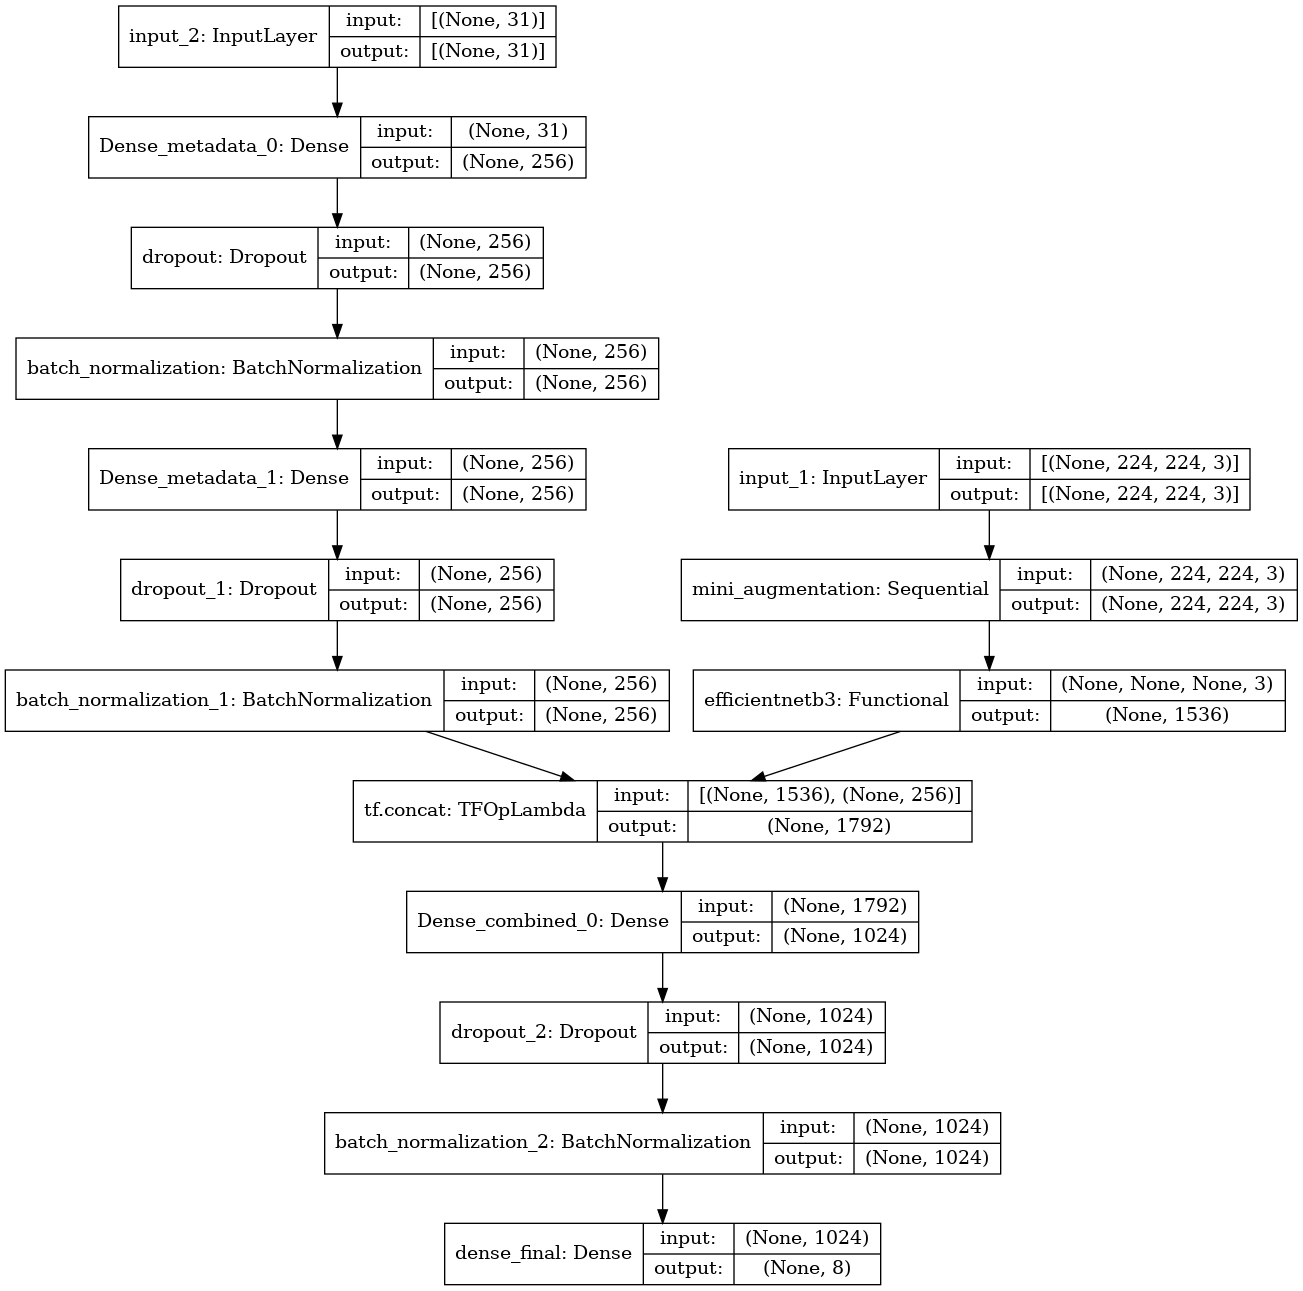

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [118]:
# Fit it
model.compile(
    loss='categorical_crossentropy',
    # optimizer="adam",
    optimizer=tf.keras.optimizers.Adam(1e-5),  # start low
    metrics=metrics,
)

callbacks = [
    CustomCallback(),
    # tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max'),
]
tf.keras.backend.clear_session()

# train_ds_repackaged_reshuffled = train_ds_repackaged.shuffle(buffer_size=100, seed=random_seed, reshuffle_each_iteration=True)

history = model.fit(
    train_ds_repackaged,
    validation_data=validation_ds_repackaged,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
plot_history_df(history_df)

Epoch 1/50
500/500 [==============================] - 106s 196ms/step - loss: 2.6841 - accuracy: 0.1251 - precision: 0.1177 - recall: 0.0239 - auc_pr: 0.1247 - auc_roc: 0.4997 - f1_score: 0.1205 - val_loss: 2.4357 - val_accuracy: 0.1076 - val_precision: 0.0916 - val_recall: 0.0059 - val_auc_pr: 0.1134 - val_auc_roc: 0.4647 - val_f1_score: 0.0842
*Epoch 2/50
500/500 [==============================] - 98s 192ms/step - loss: 2.5961 - accuracy: 0.1245 - precision: 0.1352 - recall: 0.0259 - auc_pr: 0.1250 - auc_roc: 0.4994 - f1_score: 0.1245 - val_loss: 2.3563 - val_accuracy: 0.1111 - val_precision: 0.1319 - val_recall: 0.0059 - val_auc_pr: 0.1212 - val_auc_roc: 0.4900 - val_f1_score: 0.0856
*Epoch 3/50
500/500 [==============================] - 96s 188ms/step - loss: 2.5403 - accuracy: 0.1208 - precision: 0.1293 - recall: 0.0191 - auc_pr: 0.1242 - auc_roc: 0.4984 - f1_score: 0.1207 - val_loss: 2.3417 - val_accuracy: 0.1140 - val_precision: 0.1250 - val_recall: 0.0054 - val_auc_pr: 0.1206 -

KeyboardInterrupt: 